In [1]:
! pip install transformers sentencepiece datasets
! pip install tqdm
! pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# from huggingface_hub import crate_branch
from huggingface_hub import notebook_login
notebook_login()


# Data preparation

In [3]:
import torch
import numpy as np
from datasets import load_dataset, DatasetDict
from google.colab import drive
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
)
from typing import Dict, List, Tuple, Optional
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
from torch import optim
from torch.nn import functional as F
import glob
import os
import gc
from tqdm.notebook import tqdm
from huggingface_hub import HfFolder
from huggingface_hub import HfApi, Repository, hf_hub_download

sns.set_style('dark')

from google.colab import drive
drive.mount('/content/drive')
curfile = os.getcwd()
print(curfile)


# Model and configuration parameters
model_name = 'google/mt5-small'
# branch_used="recovery"
max_length = 128
batch_size = 8
learning_rate = 5e-5
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Language tokens
lang_token = {
    'en': '<en>',
    'sw': '<sw>'
}

api = HfApi()  # Initialize the API client once
repo_id="Lingua-Connect/JMW_TrainerImproved"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.to(device)

repo_name="Lingua-Connect/JMW_TrainerImproved"
checkpoint_file = "checkpoint.pth"

# Add special tokens
special_tokens = {'additional_special_tokens': list(lang_token.values())}
tokenizer.add_special_tokens(special_tokens)
model.resize_token_embeddings(len(tokenizer))

# Load the dataset and check available splits
dataset = load_dataset('Rogendo/English-Swahili-Sentence-Pairs')
print("Available splits:", dataset.keys())


# Calculate the sizes based on percentages
total_rows = len(dataset['train'])
train_size = int(0.8 * total_rows)  # 80% for training
validation_size = int(0.1 * total_rows)  # 10% for validation
test_size = total_rows - train_size - validation_size  # Remaining 10% for test

# Shuffle the dataset to ensure randomness in splitting
ds_shuffled = dataset['train'].shuffle(seed=42)

# Create the splits based on the specified sizes
train_dataset = ds_shuffled.select(range(train_size)) # train_dataset should be a dataset, not an int
validation_dataset = ds_shuffled.select(range(train_size, train_size + validation_size))
test_dataset = ds_shuffled.select(range(train_size + validation_size, train_size + validation_size + test_size))

new_dataset = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

# Print the new dataset structure
print(new_dataset)

Mounted at /content/drive
/content


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/173 [00:00<?, ?B/s]

ensw.csv:   0%|          | 0.00/21.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/210471 [00:00<?, ? examples/s]

Available splits: dict_keys(['train'])
DatasetDict({
    train: Dataset({
        features: ['English sentence', 'Swahili Translation'],
        num_rows: 168376
    })
    validation: Dataset({
        features: ['English sentence', 'Swahili Translation'],
        num_rows: 21047
    })
    test: Dataset({
        features: ['English sentence', 'Swahili Translation'],
        num_rows: 21048
    })
})


# Preprocessor

In [4]:
import torch
from typing import Dict, List, Tuple, Optional, Union, Iterator
from dataclasses import dataclass
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from enum import Enum

class TranslationDirection(Enum):
    """Enum for translation directions"""
    EN2SW = "en2sw"
    SW2EN = "sw2en"

@dataclass
class TranslationPair:
    """Data class for holding translation pairs."""
    source_text: str
    target_text: str
    source_lang: str
    target_lang: str

    def __post_init__(self):
        """Validate inputs upon initialization."""
        # Convert None to empty string to avoid attribute errors
        self.source_text = str(self.source_text or "")
        self.target_text = str(self.target_text or "")
        self.source_lang = str(self.source_lang or "")
        self.target_lang = str(self.target_lang or "")

    def is_valid(self) -> bool:
        """Check if the translation pair is valid for training."""
        return (bool(self.source_text.strip()) and
                bool(self.target_text.strip()) and
                bool(self.source_lang.strip()) and
                bool(self.target_lang.strip()))

class TranslationPreprocessor:
    def __init__(self, tokenizer: AutoTokenizer, lang_tokens: Dict[str, str], max_length: int):
        """
        Initialize the preprocessor.

        Args:
            tokenizer: HuggingFace tokenizer
            lang_tokens: Dictionary mapping language codes to tokens
            max_length: Maximum sequence length
        """
        self.tokenizer = tokenizer
        self.lang_tokens = lang_tokens
        self.max_length = max_length
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.key_mapping = {
            TranslationDirection.EN2SW.value: ("English sentence", "Swahili Translation"),
            TranslationDirection.SW2EN.value: ("Swahili Translation", "English sentence")
        }

    def add_language_token(self, text: str, lang_code: str) -> str:
        """Prepend language-specific token to text."""
        return f"{self.lang_tokens[lang_code]} {text}"

    def encode_input_str(self, text: str, target_lang: str, tokenizer: AutoTokenizer, seq_len: int, lang_token: Dict[str, str]) -> torch.Tensor:
        """Encode input string with source language token"""
        # Use source language token (English)
        source_lang_token = lang_token['en']

        # Tokenize with English token
        input_ids = tokenizer.encode(
            text=f"{source_lang_token} {text}",
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            max_length=seq_len
        )

        return input_ids[0]

    def encode_target_str(self, text: str, tokenizer: AutoTokenizer, seq_len: int, lang_token: Dict[str, str]) -> torch.Tensor:
        """Encode target string with target language token"""
        # For target, we'll keep the Swahili token as it's the target language
        target_lang_token = lang_token['sw']

        token_ids = tokenizer.encode(
            text=f"{target_lang_token} {text}",
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            max_length=seq_len
        )

        return token_ids[0]

    def format_translation_data(self, translations: Dict[str, str], lang_token: Dict[str, str], tokenizer: AutoTokenizer, seq_len: int = 20) -> Optional[Tuple[torch.Tensor, torch.Tensor]]:
        """Format translation data for model input"""
        # Define possible input-output language pairs and randomly select one
        input_lang, target_lang = 'en', 'sw'

        # Map language codes to column names
        column_map = {
            'en': 'English sentence',
            'sw': 'Swahili Translation'
        }

        # Extract the translations based on the chosen direction
        input_text = translations.get(column_map[input_lang])
        target_text = translations.get(column_map[target_lang])

        # Check for any missing translations
        if input_text is None or target_text is None:
            return None

        # Tokenize input with English as source language
        input_token_ids = self.encode_input_str(
            text=input_text,
            target_lang='sw',
            tokenizer=tokenizer,
            seq_len=seq_len,
            lang_token=lang_token
        )

        # Tokenize target text
        target_token_ids = self.encode_target_str(
            text=target_text,
            tokenizer=tokenizer,
            seq_len=seq_len,
            lang_token=lang_token
        )

        return input_token_ids, target_token_ids

    def transform_batch(self, batch: Dict[str, List[str]], lang_token: Dict[str, str], tokenizer: AutoTokenizer, max_length: int) -> Optional[Tuple[torch.Tensor, torch.Tensor]]:
        """Transform a batch of translations"""
        inputs = []
        targets = []

        # Get all English sentences and Swahili translations from the batch
        english_sentences = batch['English sentence']
        swahili_translations = batch['Swahili Translation']

        # Process each pair in the batch
        for eng, swa in zip(english_sentences, swahili_translations):
            translation_set = {
                'English sentence': eng,
                'Swahili Translation': swa
            }

            # Process the translation pair
            formatted_data = self.format_translation_data(
                translation_set,
                lang_token,
                tokenizer,
                max_length
            )

            if formatted_data is None:
                continue

            input_ids, target_ids = formatted_data
            inputs.append(input_ids.unsqueeze(0))
            targets.append(target_ids.unsqueeze(0))

        if not inputs or not targets:  # Check if we have any valid translations
            return None

        # Concatenate tensors for batch
        device = "cuda" if torch.cuda.is_available() else "cpu"
        batch_input_ids = torch.cat(inputs).to(device)
        batch_target_ids = torch.cat(targets).to(device)

        return batch_input_ids, batch_target_ids

    def get_data_generator(self, dataset, lang_token: Dict[str, str], tokenizer: AutoTokenizer, batch_size: int = 8, direction: TranslationDirection = TranslationDirection.EN2SW) -> Iterator[Tuple[torch.Tensor, torch.Tensor]]:
        """Generate batches of processed translation data"""
        # dataset = dataset.shuffle()
        for i in range(0, len(dataset), batch_size):
            end_idx = min(i + batch_size, len(dataset))
            batch = dataset[i:end_idx]
            batch_dict = {
                'English sentence': batch['English sentence'],
                'Swahili Translation': batch['Swahili Translation']
            }
            processed_batch = self.transform_batch(batch, lang_token, tokenizer, self.max_length)
            if processed_batch is not None:
                yield processed_batch

    def process_translation_pair(self, pair: TranslationPair) -> Tuple[torch.Tensor, torch.Tensor]:
        """Process a single translation pair"""
        # Add language tokens to source and target texts
        source_text_with_token = self.add_language_token(pair.source_text, pair.source_lang)
        target_text_with_token = self.add_language_token(pair.target_text, pair.target_lang)

        # Tokenize source and target texts
        source_ids = self.tokenizer.encode(
            source_text_with_token,
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            max_length=self.max_length
        )

        target_ids = self.tokenizer.encode(
            target_text_with_token,
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            max_length=self.max_length
        )

        return source_ids[0], target_ids[0]

# Optimizer and Scheduler

In [5]:

from transformers import get_cosine_schedule_with_warmup
from torch.optim import AdamW
import math
import numpy as np

# Configurable parameters
learning_rate = 5e-5
epsilon_value = 1e-8
batch_size = 8
num_epochs = 10

# Optimizer setup
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    eps=epsilon_value,
)

# Calculate steps
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = num_epochs * n_batches
num_warmup_steps = int(0.05 * total_steps)  # 5% warmup

# Use standard cosine scheduler
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)

# Debugging function
def print_lr_details(optimizer, scheduler, step):
    print(f"Step {step}:")
    print(f"  Base LR: {optimizer.param_groups[0]['lr']:.2e}")
    print(f"  Scheduler LR: {scheduler.get_last_lr()[0]:.2e}")

# Example usage (replace with your actual training loop)
for step in range(5):
   print_lr_details(optimizer, scheduler, step)
   optimizer.step()
   scheduler.step()

Step 0:
  Base LR: 0.00e+00
  Scheduler LR: 0.00e+00
Step 1:
  Base LR: 4.75e-09
  Scheduler LR: 4.75e-09
Step 2:
  Base LR: 9.50e-09
  Scheduler LR: 9.50e-09
Step 3:
  Base LR: 1.43e-08
  Scheduler LR: 1.43e-08
Step 4:
  Base LR: 1.90e-08
  Scheduler LR: 1.90e-08


# Checkpoint Manager

In [6]:
import torch
from huggingface_hub import HfApi, hf_hub_download
import os
import gc
import matplotlib.pyplot as plt

class CheckpointManager:
    def __init__(self, model, optimizer, scheduler, tokenizer, repo_name, device, branch_name="main"):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.tokenizer = tokenizer
        self.repo_name = repo_name
        self.device = device
        self.branch_name = branch_name
        self.api = HfApi()
        self.batches_per_epoch = None

    def set_dataset_info(self, num_samples, batch_size):
        """Store dataset info for accurate step calculations"""
        self.batches_per_epoch = int(np.ceil(num_samples / batch_size))
        self.batch_size = batch_size
        self.num_samples = num_samples
        print(f"CheckpointManager: Batches per epoch set to {self.batches_per_epoch}")


    def save_checkpoint(self, epoch, batch_idx, losses, total_steps=None, steps_taken=None, repo_name=None, branch_name=None):
        repo_name = repo_name or self.repo_name
        branch_name = branch_name or self.branch_name

        try:
            # Calculate steps_taken if not provided, using the stored batches_per_epoch
            if steps_taken is None and self.batches_per_epoch is not None:
                steps_taken = epoch * self.batches_per_epoch + batch_idx
                print(f"Calculated steps_taken for saving: {steps_taken}")

            # Get current learning rates
            current_lr = self.optimizer.param_groups[0]['lr']
            scheduler_lr = self.scheduler.get_last_lr()[0]

            # Prepare the checkpoint dictionary with enhanced information
            checkpoint = {
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'epoch': epoch,
                'batch': batch_idx,
                'losses': losses,
                'current_lr': current_lr,
                'scheduler_lr': scheduler_lr,
                'total_steps': total_steps,
                'batches_per_epoch': self.batches_per_epoch,
                'steps_taken': steps_taken if steps_taken is not None else (epoch * batch_idx)
            }

            # Save the checkpoint locally
            torch.save(checkpoint, 'checkpoint.pth')
            print(f"Checkpoint saved locally with learning rate: {current_lr:.2e}, scheduler lr: {scheduler_lr:.2e}")
            print(f"Saved at epoch {epoch + 1}, batch {batch_idx}, steps_taken: {steps_taken}")

            # Ensure all tensors in the model are contiguous
            for param in self.model.parameters():
                param.data = param.data.contiguous()

            # Upload model to Hugging Face Hub
            self.model.push_to_hub(
                repo_id=repo_name,
                commit_message=f"Checkpoint after epoch {epoch + 1}, batch {batch_idx}",
                use_temp_dir=True,
                revision=branch_name
            )

            # Upload tokenizer to Hugging Face Hub
            self.tokenizer.push_to_hub(
                repo_id=repo_name,
                revision=branch_name
            )

            # Upload checkpoint file to Hugging Face Hub
            self.api.upload_file(
                path_or_fileobj="checkpoint.pth",
                path_in_repo="checkpoint.pth",
                repo_id=repo_name,
                revision=branch_name
            )

            # Upload notebook if available
            notebook_path = "/content/drive/MyDrive/Colab Notebooks/progress.ipynb"
            if os.path.exists(notebook_path):
                self.api.upload_file(
                    path_or_fileobj=notebook_path,
                    path_in_repo="current_notebook.ipynb",
                    repo_id=repo_name,
                    revision=branch_name
                )

            print("Checkpoint file uploaded to Hugging Face Hub.")
            print(f"Checkpoint saved to Hugging Face Hub after epoch {epoch + 1}, batch {batch_idx}")

        except Exception as e:
            print(f"Error saving checkpoint: {e}")

    def load_checkpoint(self, repo_name=None, branch_name=None):
        repo_name = repo_name or self.repo_name
        branch_name = branch_name or self.branch_name

        try:
            # Clear memory before loading checkpoint
            torch.cuda.empty_cache()
            gc.collect()

            # Check if the checkpoint file exists in the repo
            if self.checkpoint_exists(repo_name, "checkpoint.pth", branch_name):
                # Download the checkpoint file
                checkpoint_path = hf_hub_download(
                    repo_id=repo_name,
                    filename="checkpoint.pth",
                    revision=branch_name
                )

                # Load the checkpoint
                checkpoint = torch.load(checkpoint_path, map_location=self.device)

                # Store learning rate before loading for comparison
                prev_lr = self.optimizer.param_groups[0]['lr'] if self.optimizer else None
                prev_scheduler_lr = self.scheduler.get_last_lr()[0] if self.scheduler else None

                # Load model, optimizer, and scheduler states
                self.model.load_state_dict(checkpoint['model_state_dict'])
                self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

                # Load training state
                epoch_idx = checkpoint['epoch']
                batch_idx = checkpoint['batch']
                losses = checkpoint['losses']

                # Extract additional information (with backward compatibility)
                current_lr = checkpoint.get('current_lr', self.optimizer.param_groups[0]['lr'])
                scheduler_lr = checkpoint.get('scheduler_lr', self.scheduler.get_last_lr()[0])
                steps_taken = checkpoint.get('steps_taken', None)
                total_steps = checkpoint.get('total_steps', None)

                if steps_taken is None and self.batches_per_epoch is not None:
                    # Calculate steps_taken from epoch and batch_idx
                    steps_taken = epoch_idx * self.batches_per_epoch + batch_idx
                    print(f"Calculated steps_taken from epoch/batch: {steps_taken}")

                # Verify learning rates
                print(f"LR before checkpoint loading: {prev_lr:.2e}, After: {self.optimizer.param_groups[0]['lr']:.2e}")
                print(f"Scheduler LR before: {prev_scheduler_lr:.2e}, After: {self.scheduler.get_last_lr()[0]:.2e}")
                print(f"Checkpoint saved with LR: {current_lr:.2e}, Scheduler LR: {scheduler_lr:.2e}")

                # Verify if the learning rates match up
                if abs(self.optimizer.param_groups[0]['lr'] - current_lr) > 1e-8:
                    print("WARNING: Current learning rate doesn't match the checkpoint's saved learning rate!")

                print(f"Loaded checkpoint from epoch {epoch_idx + 1}, batch {batch_idx}")

                if steps_taken is not None:
                    print(f"Steps taken according to checkpoint: {steps_taken}")
                    if self.batches_per_epoch is not None:
                        expected_steps = epoch_idx * self.batches_per_epoch + batch_idx
                        if expected_steps != steps_taken:
                            print(f"WARNING: Expected steps ({expected_steps}) doesn't match steps_taken in checkpoint ({steps_taken})!")

                return epoch_idx, batch_idx, losses, steps_taken, total_steps

            else:
                print("No checkpoint file found in the repository.")

        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            torch.cuda.empty_cache()
            gc.collect()

        print("No checkpoint found or error occurred. Starting training from scratch.")
        return 0, 0, [], 0, None  # Start from epoch 0, batch 0, empty losses list, 0 steps

    def checkpoint_exists(self, repo_name, filename, branch_name):
        try:
            # List all files in the specified branch
            files = self.api.list_repo_files(repo_id=repo_name, revision=branch_name)
            return filename in files
        except Exception as e:
            print(f"Error checking for checkpoint: {e}")
            return False

# Evaluate

In [7]:
def eval_model(model, val_dataset, tokenizer, LANG_TOKEN_MAPPING):
    model.eval()
    total_val_loss = 0
    val_data_generator = preprocessor.get_data_generator(
        val_dataset, LANG_TOKEN_MAPPING, tokenizer, batch_size=batch_size
    )
    total_val_batches = len(val_dataset) // batch_size
    if len(val_dataset) % batch_size != 0:
        total_val_batches += 1

    with torch.no_grad():
        for batch_idx, (input_batch, label_batch) in enumerate(val_data_generator):
            input_batch = input_batch.to(device)
            label_batch = label_batch.to(device)
            outputs = model(input_ids=input_batch, labels=label_batch)
            total_val_loss += outputs.loss.item()

    avg_val_loss = total_val_loss / total_val_batches
    return avg_val_loss

# Bleu Score

In [8]:
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu(predictions, references):
    """
    Calculate BLEU score given predictions and references.

    Args:
        predictions: List of predicted translations (list of strings).
        references: List of reference translations (list of strings).

    Returns:
        bleu_score: The computed BLEU score.
    """
    # Wrap each reference in a list (required by corpus_bleu)
    references = [[ref] for ref in references]

    # Compute BLEU score
    bleu_score = corpus_bleu(references, predictions)
    return bleu_score

# Training loop

In [9]:
%matplotlib inline
from transformers import get_cosine_schedule_with_warmup
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

def plot_training_history(history):
    """
    Plot training loss, validation loss, and BLEU scores.

    Args:
        history: Dictionary containing training and validation metrics.
    """
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot BLEU score
    plt.subplot(1, 2, 2)
    plt.plot(history['val_bleu'], label='Validation BLEU', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('BLEU Score')
    plt.title('Validation BLEU Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

def train_model(
    model, train_dataset, val_dataset, optimizer, scheduler, num_epochs, device, tokenizer,
    preprocessor, LANG_TOKEN_MAPPING, batch_size=8, checkpoint_frequency=10000, max_length=128,
    learning_rate=5e-5, print_freq=100, repo_name="Lingua-Connect/JMW_TrainerImproved"
):
    """
    Train the model with checkpointing, validation, and BLEU score calculation.
    """
    # Memory management and initialization
    torch.cuda.empty_cache()
    gc.collect()

    # Move model to device
    model.to(device)

    # Store training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_bleu': [],
    }

    # Calculate total batches and steps
    n_batches = int(np.ceil(len(train_dataset) / batch_size))
    total_steps = num_epochs * n_batches

    # Adjust warmup ratio to 5%
    num_warmup_steps = int(0.05 * total_steps)  # 5% warmup
    print(f"Number of warmup steps: {num_warmup_steps}")
    print(f"Total training steps: {total_steps}")
    print(f"Batches per epoch: {n_batches}")

    # Initialize CheckpointManager
    checkpoint_manager = CheckpointManager(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        tokenizer=tokenizer,
        repo_name=repo_name,
        device=device
    )

    # Set dataset info for accurate calculations
    checkpoint_manager.set_dataset_info(len(train_dataset), batch_size)

    # Load checkpoint if it exists - pass dataset info here
    start_epoch, start_batch, losses, steps_taken, checkpoint_total_steps = checkpoint_manager.load_checkpoint()

    # Check if total_steps has changed and print warning
    if checkpoint_total_steps is not None and checkpoint_total_steps != total_steps:
        print(f"WARNING: Total steps in checkpoint ({checkpoint_total_steps}) differs from current setting ({total_steps})")

    # Manually adjust the scheduler state if resuming from a checkpoint
    if start_epoch > 0 or start_batch > 0:
        current_steps = steps_taken if steps_taken is not None else (start_epoch * n_batches + start_batch)
        expected_steps = start_epoch * n_batches + start_batch

        print(f"Checkpoint indicates {current_steps} steps taken, calculated steps: {expected_steps}")

        # If steps_taken is not available, manually step the scheduler
        if steps_taken is None:
            print(f"Stepping scheduler {expected_steps} times to match checkpoint position")
            # Reset scheduler to initial state
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps
            )
            # Step to match checkpoint position
            for _ in range(expected_steps):
                scheduler.step()

        print(f"Learning rate after scheduler adjustment: {optimizer.param_groups[0]['lr']:.2e}")
        print(f"Scheduler learning rate after adjustment: {scheduler.get_last_lr()[0]:.2e}")

    # Check if training has already completed
    if start_epoch >= num_epochs:
        print(f"Training already completed. Checkpoint found at epoch {start_epoch}, batch {start_batch}.")
        return history, start_batch

     # Training loop
    last_batch_idx = 0 # initialize last_batch_idx
    for epoch in range(start_epoch, num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print(f"Starting from batch: {start_batch if epoch == start_epoch else 0}")
        print(f"Current learning rate: {optimizer.param_groups[0]['lr']:.2e}")
        print(f"Current scheduler learning rate: {scheduler.get_last_lr()[0]:.2e}")

        model.train()
        total_train_loss = sum(losses) if epoch == start_epoch and losses else 0
        processed_train_samples = 0

        # total_train_loss = 0
        # processed_train_samples = 0
        # epoch_batch_count = 0

        # Create data generator for this epoch
        train_data_generator = preprocessor.get_data_generator(
            train_dataset, LANG_TOKEN_MAPPING, tokenizer, batch_size=batch_size
        )

        # Calculate total number of batches
        total_batches = len(train_dataset) // batch_size
        if len(train_dataset) % batch_size != 0:
            total_batches += 1

        # Training progress bar
        pbar = tqdm(train_data_generator, total=total_batches, desc=f"Epoch {epoch + 1}/{num_epochs}", ncols=100)

        # Keep track of steps for this session
        session_steps = 0
        current_batch_idx = 0  # Track actual batch index

        # Reset losses at the start of each epoch
        # losses = [] if epoch != start_epoch else losses[start_batch:]

        for batch_idx, (input_batch, label_batch) in enumerate(pbar):
            try:
                current_batch_idx = batch_idx  # Update current batch index
                # Skip batches already processed in the checkpoint
                if epoch == start_epoch and batch_idx < start_batch:
                    continue

                # Memory management
                torch.cuda.empty_cache()

                # Move batches to device
                input_batch = input_batch.to(device)
                label_batch = label_batch.to(device)

                # Zero gradients
                optimizer.zero_grad()

                # Forward pass with memory management
                try:
                    outputs = model(input_ids=input_batch, labels=label_batch)
                    loss = outputs.loss
                except RuntimeError as e:
                    if 'CUDA out of memory' in str(e):
                        print("Out of memory error. Clearing memory and retrying.")
                        torch.cuda.empty_cache()
                        gc.collect()
                        continue
                    else:
                        raise

                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()
                session_steps += 1

                # Update metrics
                current_loss = loss.item()
                losses.append(current_loss)
                total_train_loss += current_loss
                # epoch_batch_count += 1
                processed_train_samples += input_batch.size(0)

                # Calculate steps taken more accurately
                steps_from_previous_epochs = start_epoch * n_batches
                steps_from_current_epoch = session_steps
                if epoch == start_epoch:
                    steps_from_current_epoch += start_batch
                total_steps_taken = steps_from_previous_epochs + steps_from_current_epoch

                # Update progress bar
                current_avg_loss = total_train_loss / (len(losses) if epoch == start_epoch else (batch_idx + 1 - (start_batch if epoch == start_epoch else 0)))
                pbar.set_postfix({
                    "loss": current_loss,
                    "avg_loss": current_avg_loss,
                    "lr": scheduler.get_last_lr()[0],
                    "steps": total_steps_taken
                })

                # Periodic evaluation and checkpoint
                if (batch_idx + 1) % print_freq == 0:
                    avg_loss = np.mean(losses[-print_freq:])
                    print(f'Epoch: {epoch + 1} | Step: {batch_idx + 1} | Avg. loss: {avg_loss:.3f} | lr: {scheduler.get_last_lr()[0]:.2e} | Total steps: {total_steps_taken}')

                # Save checkpoint periodically
                if (batch_idx + 1) % checkpoint_frequency == 0:
                    val_loss = eval_model(model, val_dataset, tokenizer, LANG_TOKEN_MAPPING)
                    print(f'Epoch {epoch + 1} | Step {batch_idx + 1}: Validation loss = {val_loss:.3f}')
                    checkpoint_manager.save_checkpoint(
                        epoch=epoch,
                        batch_idx=batch_idx + 1,
                        losses=losses,
                        total_steps=total_steps,
                        steps_taken=total_steps_taken
                    )
                    print(f"Checkpoint saved for epoch {epoch + 1}, batch {batch_idx + 1}")
                last_batch_idx = batch_idx # update last_batch_idx
            except Exception as e:
                print(f"\nError processing training batch {batch_idx}: {str(e)}")

                # Save checkpoint before exiting in case of error
                steps_from_previous_epochs = start_epoch * n_batches
                steps_from_current_epoch = session_steps
                if epoch == start_epoch:
                    steps_from_current_epoch += start_batch
                total_steps_taken = steps_from_previous_epochs + steps_from_current_epoch
                checkpoint_manager.save_checkpoint(
                    epoch=epoch,
                    batch_idx=batch_idx,
                    losses=losses,
                    total_steps=total_steps,
                    steps_taken=total_steps_taken
                )
                print(f"Checkpoint saved after error at epoch {epoch + 1}, batch {batch_idx}")
                continue

        pbar.close()

        # Calculate average training loss
        # avg_train_loss = total_train_loss / total_batches if total_batches > 0 else 0
        avg_train_loss = total_train_loss / len(losses)
        history['train_loss'].append(avg_train_loss)
        print(f"Average Training Loss: {avg_train_loss:.4f}")

        # Validation loop
        model.eval()
        total_val_loss = 0
        predictions = []
        references = []

        # Create validation data generator
        val_data_generator = preprocessor.get_data_generator(
            val_dataset, LANG_TOKEN_MAPPING, tokenizer, batch_size=batch_size
        )

        # Calculate total number of validation batches
        total_val_batches = len(val_dataset) // batch_size
        if len(val_dataset) % batch_size != 0:
            total_val_batches += 1

        # Validation progress bar
        pbar = tqdm(val_data_generator, total=total_val_batches, desc="Validating", ncols=100)

        with torch.no_grad():
            for batch_idx, (input_batch, label_batch) in enumerate(pbar):
                try:
                    # Move batches to device
                    input_batch = input_batch.to(device)
                    label_batch = label_batch.to(device)

                    # Calculate validation loss
                    model_outputs = model(input_ids=input_batch, labels=label_batch)
                    total_val_loss += model_outputs.loss.item()

                    # Generate translations
                    outputs = model.generate(input_batch, max_length=max_length)

                    # Decode predictions and references
                    pred_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
                    ref_texts = tokenizer.batch_decode(label_batch, skip_special_tokens=True)

                    predictions.extend(pred_texts)
                    references.extend(ref_texts)

                    # Update progress bar
                    current_avg_val_loss = total_val_loss / (batch_idx + 1)
                    pbar.set_postfix({"val_loss": current_avg_val_loss})

                except Exception as e:
                    print(f"Error processing validation batch {batch_idx}: {str(e)}")
                    continue

        pbar.close()

        # Calculate average validation loss
        avg_val_loss = total_val_loss / total_val_batches
        history['val_loss'].append(avg_val_loss)

        # Calculate BLEU score
        bleu_score = calculate_bleu(predictions, references)
        history['val_bleu'].append(bleu_score)
        print(f"Validation BLEU: {bleu_score:.4f}")

        # Save checkpoint at the end of the epoch
        total_steps_taken = (epoch + 1) * n_batches  # End of epoch
        checkpoint_manager.save_checkpoint(
            # epoch=epoch,
            # batch_idx=last_batch_idx,  # Last processed batch
            epoch=epoch + 1,  # Save as the start of the next epoch
            batch_idx=0,       # Start from batch 0 of next epoch
            losses=losses,
            total_steps=total_steps,
            steps_taken=total_steps_taken
        )

        # Print epoch summary
        print(f"\nEpoch {epoch + 1} Summary:")
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"BLEU Score: {bleu_score:.4f}")
        print(f"Final Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")

    # Plot training history
    plot_training_history(history)

    return history, last_batch_idx  # return last_batch_idx

# Run loop

Number of warmup steps: 10523
Total training steps: 210470
Batches per epoch: 21047
CheckpointManager: Batches per epoch set to 21047


checkpoint.pth:   0%|          | 0.00/3.60G [00:00<?, ?B/s]

<ipython-input-6-15cb8da38174>:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=self.device)


LR before checkpoint loading: 2.38e-08, After: 5.64e-07
Scheduler LR before: 2.38e-08, After: 5.64e-07
Checkpoint saved with LR: 5.64e-07, Scheduler LR: 5.64e-07
Loaded checkpoint from epoch 10, batch 7500
Steps taken according to checkpoint: 175876
Checkpoint indicates 175876 steps taken, calculated steps: 196923
Learning rate after scheduler adjustment: 5.64e-07
Scheduler learning rate after adjustment: 5.64e-07

Epoch 10/10
Starting from batch: 7500
Current learning rate: 5.64e-07
Current scheduler learning rate: 5.64e-07


Epoch 10/10:  36%|███████████████▋                            | 7486/21047 [00:36<01:02, 215.64it/s]Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Epoch 10/10:  36%|▎| 7600/21047 [01:31<1:58:47,  1.89it/s, loss=0.186, avg_loss=0.643, lr=5.55e-7, s

Epoch: 10 | Step: 7600 | Avg. loss: 0.198 | lr: 5.55e-07 | Total steps: 197023


Epoch 10/10:  37%|▎| 7700/21047 [02:24<1:59:58,  1.85it/s, loss=0.134, avg_loss=0.642, lr=5.47e-7, s

Epoch: 10 | Step: 7700 | Avg. loss: 0.208 | lr: 5.47e-07 | Total steps: 197123


Epoch 10/10:  37%|▎| 7800/21047 [03:19<1:59:53,  1.84it/s, loss=0.168, avg_loss=0.642, lr=5.39e-7, s

Epoch: 10 | Step: 7800 | Avg. loss: 0.203 | lr: 5.39e-07 | Total steps: 197223


Epoch 10/10:  38%|▍| 7900/21047 [04:14<2:00:12,  1.82it/s, loss=0.268, avg_loss=0.642, lr=5.31e-7, s

Epoch: 10 | Step: 7900 | Avg. loss: 0.203 | lr: 5.31e-07 | Total steps: 197323


Epoch 10/10:  38%|▍| 8000/21047 [05:10<2:02:31,  1.77it/s, loss=0.26, avg_loss=0.642, lr=5.23e-7, st

Epoch: 10 | Step: 8000 | Avg. loss: 0.204 | lr: 5.23e-07 | Total steps: 197423


Epoch 10/10:  38%|▍| 8100/21047 [06:05<2:00:29,  1.79it/s, loss=0.102, avg_loss=0.641, lr=5.15e-7, s

Epoch: 10 | Step: 8100 | Avg. loss: 0.188 | lr: 5.15e-07 | Total steps: 197523


Epoch 10/10:  39%|▍| 8200/21047 [07:01<1:59:16,  1.80it/s, loss=0.237, avg_loss=0.641, lr=5.07e-7, s

Epoch: 10 | Step: 8200 | Avg. loss: 0.182 | lr: 5.07e-07 | Total steps: 197623


Epoch 10/10:  39%|▍| 8300/21047 [07:57<1:58:10,  1.80it/s, loss=0.185, avg_loss=0.641, lr=4.99e-7, s

Epoch: 10 | Step: 8300 | Avg. loss: 0.210 | lr: 4.99e-07 | Total steps: 197723


Epoch 10/10:  40%|▍| 8400/21047 [08:53<1:57:03,  1.80it/s, loss=0.157, avg_loss=0.641, lr=4.91e-7, s

Epoch: 10 | Step: 8400 | Avg. loss: 0.203 | lr: 4.91e-07 | Total steps: 197823


Epoch 10/10:  40%|▍| 8500/21047 [09:49<1:58:50,  1.76it/s, loss=0.0736, avg_loss=0.641, lr=4.84e-7, 

Epoch: 10 | Step: 8500 | Avg. loss: 0.207 | lr: 4.84e-07 | Total steps: 197923


Epoch 10/10:  41%|▍| 8600/21047 [10:45<1:57:15,  1.77it/s, loss=0.178, avg_loss=0.64, lr=4.76e-7, st

Epoch: 10 | Step: 8600 | Avg. loss: 0.192 | lr: 4.76e-07 | Total steps: 198023


Epoch 10/10:  41%|▍| 8700/21047 [11:41<1:54:53,  1.79it/s, loss=0.182, avg_loss=0.64, lr=4.69e-7, st

Epoch: 10 | Step: 8700 | Avg. loss: 0.180 | lr: 4.69e-07 | Total steps: 198123


Epoch 10/10:  42%|▍| 8800/21047 [12:37<1:53:49,  1.79it/s, loss=0.17, avg_loss=0.64, lr=4.61e-7, ste

Epoch: 10 | Step: 8800 | Avg. loss: 0.196 | lr: 4.61e-07 | Total steps: 198223


Epoch 10/10:  42%|▍| 8900/21047 [13:33<1:52:38,  1.80it/s, loss=0.143, avg_loss=0.64, lr=4.53e-7, st

Epoch: 10 | Step: 8900 | Avg. loss: 0.197 | lr: 4.53e-07 | Total steps: 198323


Epoch 10/10:  43%|▍| 9000/21047 [14:29<1:52:41,  1.78it/s, loss=0.0889, avg_loss=0.639, lr=4.46e-7, 

Epoch: 10 | Step: 9000 | Avg. loss: 0.205 | lr: 4.46e-07 | Total steps: 198423


Epoch 10/10:  43%|▍| 9100/21047 [15:25<1:51:19,  1.79it/s, loss=0.176, avg_loss=0.639, lr=4.39e-7, s

Epoch: 10 | Step: 9100 | Avg. loss: 0.198 | lr: 4.39e-07 | Total steps: 198523


Epoch 10/10:  44%|▍| 9200/21047 [16:20<1:49:26,  1.80it/s, loss=0.116, avg_loss=0.639, lr=4.31e-7, s

Epoch: 10 | Step: 9200 | Avg. loss: 0.199 | lr: 4.31e-07 | Total steps: 198623


Epoch 10/10:  44%|▍| 9300/21047 [17:16<1:48:49,  1.80it/s, loss=0.227, avg_loss=0.639, lr=4.24e-7, s

Epoch: 10 | Step: 9300 | Avg. loss: 0.194 | lr: 4.24e-07 | Total steps: 198723


Epoch 10/10:  45%|▍| 9400/21047 [18:12<1:49:01,  1.78it/s, loss=0.109, avg_loss=0.639, lr=4.17e-7, s

Epoch: 10 | Step: 9400 | Avg. loss: 0.198 | lr: 4.17e-07 | Total steps: 198823


Epoch 10/10:  45%|▍| 9500/21047 [19:08<1:47:13,  1.79it/s, loss=0.0959, avg_loss=0.638, lr=4.1e-7, s

Epoch: 10 | Step: 9500 | Avg. loss: 0.198 | lr: 4.10e-07 | Total steps: 198923


Epoch 10/10:  46%|▍| 9600/21047 [20:03<1:46:07,  1.80it/s, loss=0.154, avg_loss=0.638, lr=4.03e-7, s

Epoch: 10 | Step: 9600 | Avg. loss: 0.197 | lr: 4.03e-07 | Total steps: 199023


Epoch 10/10:  46%|▍| 9700/21047 [20:59<1:44:43,  1.81it/s, loss=0.1, avg_loss=0.638, lr=3.96e-7, ste

Epoch: 10 | Step: 9700 | Avg. loss: 0.196 | lr: 3.96e-07 | Total steps: 199123


Epoch 10/10:  47%|▍| 9800/21047 [21:55<1:45:31,  1.78it/s, loss=0.0938, avg_loss=0.638, lr=3.89e-7, 

Epoch: 10 | Step: 9800 | Avg. loss: 0.201 | lr: 3.89e-07 | Total steps: 199223


Epoch 10/10:  47%|▍| 9900/21047 [22:51<1:43:59,  1.79it/s, loss=0.739, avg_loss=0.637, lr=3.82e-7, s

Epoch: 10 | Step: 9900 | Avg. loss: 0.210 | lr: 3.82e-07 | Total steps: 199323


Epoch 10/10:  48%|▍| 9999/21047 [23:47<1:42:39,  1.79it/s, loss=0.166, avg_loss=0.637, lr=3.75e-7, s

Epoch: 10 | Step: 10000 | Avg. loss: 0.194 | lr: 3.75e-07 | Total steps: 199423
Epoch 10 | Step 10000: Validation loss = 0.140
Checkpoint saved locally with learning rate: 3.75e-07, scheduler lr: 3.75e-07
Saved at epoch 10, batch 10000, steps_taken: 199423


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


checkpoint.pth:   0%|          | 0.00/3.60G [00:00<?, ?B/s]

Epoch 10/10:  48%|▍| 10000/21047 [32:41<494:03:49, 161.01s/it, loss=0.166, avg_loss=0.637, lr=3.75e-

Checkpoint file uploaded to Hugging Face Hub.
Checkpoint saved to Hugging Face Hub after epoch 10, batch 10000
Checkpoint saved for epoch 10, batch 10000


Epoch 10/10:  48%|▍| 10100/21047 [33:34<1:36:09,  1.90it/s, loss=0.0213, avg_loss=0.637, lr=3.68e-7,

Epoch: 10 | Step: 10100 | Avg. loss: 0.114 | lr: 3.68e-07 | Total steps: 199523


Epoch 10/10:  48%|▍| 10200/21047 [34:28<1:36:33,  1.87it/s, loss=0.107, avg_loss=0.637, lr=3.62e-7, 

Epoch: 10 | Step: 10200 | Avg. loss: 0.118 | lr: 3.62e-07 | Total steps: 199623


Epoch 10/10:  49%|▍| 10300/21047 [35:22<1:36:28,  1.86it/s, loss=0.0923, avg_loss=0.636, lr=3.55e-7,

Epoch: 10 | Step: 10300 | Avg. loss: 0.109 | lr: 3.55e-07 | Total steps: 199723


Epoch 10/10:  49%|▍| 10400/21047 [36:17<1:37:09,  1.83it/s, loss=0.0478, avg_loss=0.636, lr=3.49e-7,

Epoch: 10 | Step: 10400 | Avg. loss: 0.120 | lr: 3.49e-07 | Total steps: 199823


Epoch 10/10:  50%|▍| 10500/21047 [37:12<1:37:40,  1.80it/s, loss=0.0572, avg_loss=0.636, lr=3.42e-7,

Epoch: 10 | Step: 10500 | Avg. loss: 0.119 | lr: 3.42e-07 | Total steps: 199923


Epoch 10/10:  50%|▌| 10600/21047 [38:07<1:37:06,  1.79it/s, loss=0.0389, avg_loss=0.636, lr=3.36e-7,

Epoch: 10 | Step: 10600 | Avg. loss: 0.110 | lr: 3.36e-07 | Total steps: 200023


Epoch 10/10:  51%|▌| 10700/21047 [39:02<1:34:41,  1.82it/s, loss=0.0863, avg_loss=0.635, lr=3.29e-7,

Epoch: 10 | Step: 10700 | Avg. loss: 0.112 | lr: 3.29e-07 | Total steps: 200123


Epoch 10/10:  51%|▌| 10800/21047 [39:57<1:33:41,  1.82it/s, loss=0.0901, avg_loss=0.635, lr=3.23e-7,

Epoch: 10 | Step: 10800 | Avg. loss: 0.120 | lr: 3.23e-07 | Total steps: 200223


Epoch 10/10:  52%|▌| 10900/21047 [40:52<1:32:32,  1.83it/s, loss=0.105, avg_loss=0.635, lr=3.17e-7, 

Epoch: 10 | Step: 10900 | Avg. loss: 0.109 | lr: 3.17e-07 | Total steps: 200323


Epoch 10/10:  52%|▌| 11000/21047 [41:47<1:32:35,  1.81it/s, loss=0.0429, avg_loss=0.635, lr=3.1e-7, 

Epoch: 10 | Step: 11000 | Avg. loss: 0.106 | lr: 3.10e-07 | Total steps: 200423


Epoch 10/10:  53%|▌| 11100/21047 [42:43<1:32:09,  1.80it/s, loss=0.196, avg_loss=0.634, lr=3.04e-7, 

Epoch: 10 | Step: 11100 | Avg. loss: 0.118 | lr: 3.04e-07 | Total steps: 200523


Epoch 10/10:  53%|▌| 11200/21047 [43:38<1:30:04,  1.82it/s, loss=0.115, avg_loss=0.634, lr=2.98e-7, 

Epoch: 10 | Step: 11200 | Avg. loss: 0.102 | lr: 2.98e-07 | Total steps: 200623


Epoch 10/10:  54%|▌| 11300/21047 [44:33<1:29:14,  1.82it/s, loss=0.116, avg_loss=0.634, lr=2.92e-7, 

Epoch: 10 | Step: 11300 | Avg. loss: 0.106 | lr: 2.92e-07 | Total steps: 200723


Epoch 10/10:  54%|▌| 11400/21047 [45:28<1:28:29,  1.82it/s, loss=0.153, avg_loss=0.634, lr=2.86e-7, 

Epoch: 10 | Step: 11400 | Avg. loss: 0.109 | lr: 2.86e-07 | Total steps: 200823


Epoch 10/10:  55%|▌| 11500/21047 [46:23<1:28:03,  1.81it/s, loss=0.197, avg_loss=0.633, lr=2.8e-7, s

Epoch: 10 | Step: 11500 | Avg. loss: 0.101 | lr: 2.80e-07 | Total steps: 200923


Epoch 10/10:  55%|▌| 11600/21047 [47:18<1:27:10,  1.81it/s, loss=0.155, avg_loss=0.633, lr=2.75e-7, 

Epoch: 10 | Step: 11600 | Avg. loss: 0.122 | lr: 2.75e-07 | Total steps: 201023


Epoch 10/10:  56%|▌| 11700/21047 [48:13<1:25:37,  1.82it/s, loss=0.112, avg_loss=0.633, lr=2.69e-7, 

Epoch: 10 | Step: 11700 | Avg. loss: 0.104 | lr: 2.69e-07 | Total steps: 201123


Epoch 10/10:  56%|▌| 11800/21047 [49:09<1:24:10,  1.83it/s, loss=0.182, avg_loss=0.633, lr=2.63e-7, 

Epoch: 10 | Step: 11800 | Avg. loss: 0.100 | lr: 2.63e-07 | Total steps: 201223


Epoch 10/10:  57%|▌| 11900/21047 [50:04<1:23:25,  1.83it/s, loss=0.103, avg_loss=0.632, lr=2.57e-7, 

Epoch: 10 | Step: 11900 | Avg. loss: 0.109 | lr: 2.57e-07 | Total steps: 201323


Epoch 10/10:  57%|▌| 12000/21047 [50:59<1:24:28,  1.78it/s, loss=0.101, avg_loss=0.632, lr=2.52e-7, 

Epoch: 10 | Step: 12000 | Avg. loss: 0.115 | lr: 2.52e-07 | Total steps: 201423


Epoch 10/10:  57%|▌| 12100/21047 [51:54<1:23:03,  1.80it/s, loss=0.0633, avg_loss=0.632, lr=2.46e-7,

Epoch: 10 | Step: 12100 | Avg. loss: 0.106 | lr: 2.46e-07 | Total steps: 201523


Epoch 10/10:  58%|▌| 12200/21047 [52:49<1:20:50,  1.82it/s, loss=0.0827, avg_loss=0.631, lr=2.41e-7,

Epoch: 10 | Step: 12200 | Avg. loss: 0.111 | lr: 2.41e-07 | Total steps: 201623


Epoch 10/10:  58%|▌| 12300/21047 [53:44<1:20:39,  1.81it/s, loss=0.221, avg_loss=0.631, lr=2.35e-7, 

Epoch: 10 | Step: 12300 | Avg. loss: 0.114 | lr: 2.35e-07 | Total steps: 201723


Epoch 10/10:  59%|▌| 12400/21047 [54:40<1:18:34,  1.83it/s, loss=0.195, avg_loss=0.631, lr=2.3e-7, s

Epoch: 10 | Step: 12400 | Avg. loss: 0.107 | lr: 2.30e-07 | Total steps: 201823


Epoch 10/10:  59%|▌| 12500/21047 [55:35<1:19:16,  1.80it/s, loss=0.114, avg_loss=0.631, lr=2.25e-7, 

Epoch: 10 | Step: 12500 | Avg. loss: 0.107 | lr: 2.25e-07 | Total steps: 201923


Epoch 10/10:  60%|▌| 12600/21047 [56:30<1:17:19,  1.82it/s, loss=0.0636, avg_loss=0.63, lr=2.2e-7, s

Epoch: 10 | Step: 12600 | Avg. loss: 0.106 | lr: 2.20e-07 | Total steps: 202023


Epoch 10/10:  60%|▌| 12700/21047 [57:25<1:16:24,  1.82it/s, loss=0.0968, avg_loss=0.63, lr=2.14e-7, 

Epoch: 10 | Step: 12700 | Avg. loss: 0.100 | lr: 2.14e-07 | Total steps: 202123


Epoch 10/10:  61%|▌| 12800/21047 [58:20<1:15:13,  1.83it/s, loss=0.0677, avg_loss=0.63, lr=2.09e-7, 

Epoch: 10 | Step: 12800 | Avg. loss: 0.106 | lr: 2.09e-07 | Total steps: 202223


Epoch 10/10:  61%|▌| 12900/21047 [59:15<1:14:31,  1.82it/s, loss=0.17, avg_loss=0.63, lr=2.04e-7, st

Epoch: 10 | Step: 12900 | Avg. loss: 0.104 | lr: 2.04e-07 | Total steps: 202323


Epoch 10/10:  62%|▌| 13000/21047 [1:00:10<1:15:37,  1.77it/s, loss=0.0653, avg_loss=0.629, lr=1.99e-

Epoch: 10 | Step: 13000 | Avg. loss: 0.116 | lr: 1.99e-07 | Total steps: 202423


Epoch 10/10:  62%|▌| 13100/21047 [1:01:05<1:13:14,  1.81it/s, loss=0.115, avg_loss=0.629, lr=1.94e-7

Epoch: 10 | Step: 13100 | Avg. loss: 0.102 | lr: 1.94e-07 | Total steps: 202523


Epoch 10/10:  63%|▋| 13200/21047 [1:02:01<1:11:34,  1.83it/s, loss=0.097, avg_loss=0.629, lr=1.89e-7

Epoch: 10 | Step: 13200 | Avg. loss: 0.104 | lr: 1.89e-07 | Total steps: 202623


Epoch 10/10:  63%|▋| 13300/21047 [1:02:56<1:10:40,  1.83it/s, loss=0.0426, avg_loss=0.629, lr=1.85e-

Epoch: 10 | Step: 13300 | Avg. loss: 0.100 | lr: 1.85e-07 | Total steps: 202723


Epoch 10/10:  64%|▋| 13400/21047 [1:03:51<1:10:39,  1.80it/s, loss=0.093, avg_loss=0.628, lr=1.8e-7,

Epoch: 10 | Step: 13400 | Avg. loss: 0.120 | lr: 1.80e-07 | Total steps: 202823


Epoch 10/10:  64%|▋| 13500/21047 [1:04:46<1:09:40,  1.81it/s, loss=0.0525, avg_loss=0.628, lr=1.75e-

Epoch: 10 | Step: 13500 | Avg. loss: 0.109 | lr: 1.75e-07 | Total steps: 202923


Epoch 10/10:  65%|▋| 13600/21047 [1:05:41<1:08:01,  1.82it/s, loss=0.0429, avg_loss=0.628, lr=1.71e-

Epoch: 10 | Step: 13600 | Avg. loss: 0.110 | lr: 1.71e-07 | Total steps: 203023


Epoch 10/10:  65%|▋| 13700/21047 [1:06:36<1:07:22,  1.82it/s, loss=0.0586, avg_loss=0.628, lr=1.66e-

Epoch: 10 | Step: 13700 | Avg. loss: 0.107 | lr: 1.66e-07 | Total steps: 203123


Epoch 10/10:  66%|▋| 13800/21047 [1:07:31<1:05:52,  1.83it/s, loss=0.0839, avg_loss=0.627, lr=1.62e-

Epoch: 10 | Step: 13800 | Avg. loss: 0.105 | lr: 1.62e-07 | Total steps: 203223


Epoch 10/10:  66%|▋| 13900/21047 [1:08:27<1:06:26,  1.79it/s, loss=0.117, avg_loss=0.627, lr=1.57e-7

Epoch: 10 | Step: 13900 | Avg. loss: 0.099 | lr: 1.57e-07 | Total steps: 203323


Epoch 10/10:  67%|▋| 14000/21047 [1:09:22<1:05:14,  1.80it/s, loss=0.0989, avg_loss=0.627, lr=1.53e-

Epoch: 10 | Step: 14000 | Avg. loss: 0.114 | lr: 1.53e-07 | Total steps: 203423


Epoch 10/10:  67%|▋| 14100/21047 [1:10:17<1:03:32,  1.82it/s, loss=0.14, avg_loss=0.627, lr=1.49e-7,

Epoch: 10 | Step: 14100 | Avg. loss: 0.102 | lr: 1.49e-07 | Total steps: 203523


Epoch 10/10:  67%|▋| 14200/21047 [1:11:12<1:02:27,  1.83it/s, loss=0.0946, avg_loss=0.626, lr=1.44e-

Epoch: 10 | Step: 14200 | Avg. loss: 0.105 | lr: 1.44e-07 | Total steps: 203623


Epoch 10/10:  68%|▋| 14300/21047 [1:12:07<1:01:57,  1.82it/s, loss=0.103, avg_loss=0.626, lr=1.4e-7,

Epoch: 10 | Step: 14300 | Avg. loss: 0.113 | lr: 1.40e-07 | Total steps: 203723


Epoch 10/10:  68%|▋| 14400/21047 [1:13:02<1:01:47,  1.79it/s, loss=0.108, avg_loss=0.626, lr=1.36e-7

Epoch: 10 | Step: 14400 | Avg. loss: 0.105 | lr: 1.36e-07 | Total steps: 203823


Epoch 10/10:  69%|▋| 14500/21047 [1:13:57<1:00:05,  1.82it/s, loss=0.0892, avg_loss=0.626, lr=1.32e-

Epoch: 10 | Step: 14500 | Avg. loss: 0.105 | lr: 1.32e-07 | Total steps: 203923


Epoch 10/10:  69%|▋| 14600/21047 [1:14:52<58:52,  1.82it/s, loss=0.0696, avg_loss=0.625, lr=1.28e-7,

Epoch: 10 | Step: 14600 | Avg. loss: 0.109 | lr: 1.28e-07 | Total steps: 204023


Epoch 10/10:  70%|▋| 14700/21047 [1:15:47<58:02,  1.82it/s, loss=0.149, avg_loss=0.625, lr=1.24e-7, 

Epoch: 10 | Step: 14700 | Avg. loss: 0.095 | lr: 1.24e-07 | Total steps: 204123


Epoch 10/10:  70%|▋| 14800/21047 [1:16:43<57:16,  1.82it/s, loss=0.0906, avg_loss=0.625, lr=1.2e-7, 

Epoch: 10 | Step: 14800 | Avg. loss: 0.103 | lr: 1.20e-07 | Total steps: 204223


Epoch 10/10:  71%|▋| 14900/21047 [1:17:38<57:25,  1.78it/s, loss=0.0928, avg_loss=0.625, lr=1.16e-7,

Epoch: 10 | Step: 14900 | Avg. loss: 0.098 | lr: 1.16e-07 | Total steps: 204323


Epoch 10/10:  71%|▋| 15000/21047 [1:18:33<55:42,  1.81it/s, loss=0.178, avg_loss=0.624, lr=1.13e-7, 

Epoch: 10 | Step: 15000 | Avg. loss: 0.110 | lr: 1.13e-07 | Total steps: 204423


Epoch 10/10:  72%|▋| 15100/21047 [1:19:28<54:15,  1.83it/s, loss=0.0971, avg_loss=0.624, lr=1.09e-7,

Epoch: 10 | Step: 15100 | Avg. loss: 0.109 | lr: 1.09e-07 | Total steps: 204523


Epoch 10/10:  72%|▋| 15200/21047 [1:20:23<53:24,  1.82it/s, loss=0.102, avg_loss=0.624, lr=1.05e-7, 

Epoch: 10 | Step: 15200 | Avg. loss: 0.117 | lr: 1.05e-07 | Total steps: 204623


Epoch 10/10:  73%|▋| 15300/21047 [1:21:18<52:37,  1.82it/s, loss=0.0855, avg_loss=0.624, lr=1.02e-7,

Epoch: 10 | Step: 15300 | Avg. loss: 0.100 | lr: 1.02e-07 | Total steps: 204723


Epoch 10/10:  73%|▋| 15400/21047 [1:22:13<52:55,  1.78it/s, loss=0.128, avg_loss=0.623, lr=9.81e-8, 

Epoch: 10 | Step: 15400 | Avg. loss: 0.122 | lr: 9.81e-08 | Total steps: 204823


Epoch 10/10:  74%|▋| 15500/21047 [1:23:08<50:52,  1.82it/s, loss=0.192, avg_loss=0.623, lr=9.47e-8, 

Epoch: 10 | Step: 15500 | Avg. loss: 0.112 | lr: 9.47e-08 | Total steps: 204923


Epoch 10/10:  74%|▋| 15600/21047 [1:24:03<49:56,  1.82it/s, loss=0.166, avg_loss=0.623, lr=9.13e-8, 

Epoch: 10 | Step: 15600 | Avg. loss: 0.112 | lr: 9.13e-08 | Total steps: 205023


Epoch 10/10:  75%|▋| 15700/21047 [1:24:59<48:48,  1.83it/s, loss=0.139, avg_loss=0.623, lr=8.8e-8, s

Epoch: 10 | Step: 15700 | Avg. loss: 0.115 | lr: 8.80e-08 | Total steps: 205123


Epoch 10/10:  75%|▊| 15800/21047 [1:25:54<48:16,  1.81it/s, loss=0.0205, avg_loss=0.622, lr=8.47e-8,

Epoch: 10 | Step: 15800 | Avg. loss: 0.107 | lr: 8.47e-08 | Total steps: 205223


Epoch 10/10:  76%|▊| 15900/21047 [1:26:49<47:31,  1.80it/s, loss=0.124, avg_loss=0.622, lr=8.15e-8, 

Epoch: 10 | Step: 15900 | Avg. loss: 0.112 | lr: 8.15e-08 | Total steps: 205323


Epoch 10/10:  76%|▊| 16000/21047 [1:27:44<46:09,  1.82it/s, loss=0.0901, avg_loss=0.622, lr=7.84e-8,

Epoch: 10 | Step: 16000 | Avg. loss: 0.106 | lr: 7.84e-08 | Total steps: 205423


Epoch 10/10:  76%|▊| 16100/21047 [1:28:39<45:08,  1.83it/s, loss=0.0441, avg_loss=0.622, lr=7.53e-8,

Epoch: 10 | Step: 16100 | Avg. loss: 0.098 | lr: 7.53e-08 | Total steps: 205523


Epoch 10/10:  77%|▊| 16200/21047 [1:29:34<44:11,  1.83it/s, loss=0.0667, avg_loss=0.621, lr=7.23e-8,

Epoch: 10 | Step: 16200 | Avg. loss: 0.106 | lr: 7.23e-08 | Total steps: 205623


Epoch 10/10:  77%|▊| 16300/21047 [1:30:29<43:58,  1.80it/s, loss=0.0426, avg_loss=0.621, lr=6.93e-8,

Epoch: 10 | Step: 16300 | Avg. loss: 0.103 | lr: 6.93e-08 | Total steps: 205723


Epoch 10/10:  78%|▊| 16400/21047 [1:31:24<42:45,  1.81it/s, loss=0.0498, avg_loss=0.621, lr=6.64e-8,

Epoch: 10 | Step: 16400 | Avg. loss: 0.106 | lr: 6.64e-08 | Total steps: 205823


Epoch 10/10:  78%|▊| 16500/21047 [1:32:19<41:22,  1.83it/s, loss=0.205, avg_loss=0.621, lr=6.36e-8, 

Epoch: 10 | Step: 16500 | Avg. loss: 0.099 | lr: 6.36e-08 | Total steps: 205923


Epoch 10/10:  79%|▊| 16600/21047 [1:33:14<40:40,  1.82it/s, loss=0.13, avg_loss=0.62, lr=6.08e-8, st

Epoch: 10 | Step: 16600 | Avg. loss: 0.107 | lr: 6.08e-08 | Total steps: 206023


Epoch 10/10:  79%|▊| 16700/21047 [1:34:09<39:42,  1.82it/s, loss=0.129, avg_loss=0.62, lr=5.81e-8, s

Epoch: 10 | Step: 16700 | Avg. loss: 0.118 | lr: 5.81e-08 | Total steps: 206123


Epoch 10/10:  80%|▊| 16800/21047 [1:35:05<39:34,  1.79it/s, loss=0.039, avg_loss=0.62, lr=5.55e-8, s

Epoch: 10 | Step: 16800 | Avg. loss: 0.119 | lr: 5.55e-08 | Total steps: 206223


Epoch 10/10:  80%|▊| 16900/21047 [1:36:00<38:13,  1.81it/s, loss=0.126, avg_loss=0.62, lr=5.29e-8, s

Epoch: 10 | Step: 16900 | Avg. loss: 0.104 | lr: 5.29e-08 | Total steps: 206323


Epoch 10/10:  81%|▊| 17000/21047 [1:36:55<36:55,  1.83it/s, loss=0.0352, avg_loss=0.619, lr=5.04e-8,

Epoch: 10 | Step: 17000 | Avg. loss: 0.100 | lr: 5.04e-08 | Total steps: 206423


Epoch 10/10:  81%|▊| 17100/21047 [1:37:50<36:00,  1.83it/s, loss=0.0687, avg_loss=0.619, lr=4.79e-8,

Epoch: 10 | Step: 17100 | Avg. loss: 0.112 | lr: 4.79e-08 | Total steps: 206523


Epoch 10/10:  82%|▊| 17200/21047 [1:38:45<35:13,  1.82it/s, loss=0.0638, avg_loss=0.619, lr=4.55e-8,

Epoch: 10 | Step: 17200 | Avg. loss: 0.103 | lr: 4.55e-08 | Total steps: 206623


Epoch 10/10:  82%|▊| 17300/21047 [1:39:40<35:02,  1.78it/s, loss=0.187, avg_loss=0.619, lr=4.32e-8, 

Epoch: 10 | Step: 17300 | Avg. loss: 0.103 | lr: 4.32e-08 | Total steps: 206723


Epoch 10/10:  83%|▊| 17400/21047 [1:40:35<33:16,  1.83it/s, loss=0.0296, avg_loss=0.618, lr=4.09e-8,

Epoch: 10 | Step: 17400 | Avg. loss: 0.109 | lr: 4.09e-08 | Total steps: 206823


Epoch 10/10:  83%|▊| 17500/21047 [1:41:30<32:27,  1.82it/s, loss=0.052, avg_loss=0.618, lr=3.87e-8, 

Epoch: 10 | Step: 17500 | Avg. loss: 0.105 | lr: 3.87e-08 | Total steps: 206923


Epoch 10/10:  84%|▊| 17600/21047 [1:42:25<31:25,  1.83it/s, loss=0.0574, avg_loss=0.618, lr=3.65e-8,

Epoch: 10 | Step: 17600 | Avg. loss: 0.106 | lr: 3.65e-08 | Total steps: 207023


Epoch 10/10:  84%|▊| 17700/21047 [1:43:20<30:55,  1.80it/s, loss=0.0586, avg_loss=0.618, lr=3.44e-8,

Epoch: 10 | Step: 17700 | Avg. loss: 0.115 | lr: 3.44e-08 | Total steps: 207123


Epoch 10/10:  85%|▊| 17800/21047 [1:44:16<29:54,  1.81it/s, loss=0.132, avg_loss=0.617, lr=3.24e-8, 

Epoch: 10 | Step: 17800 | Avg. loss: 0.103 | lr: 3.24e-08 | Total steps: 207223


Epoch 10/10:  85%|▊| 17900/21047 [1:45:11<28:49,  1.82it/s, loss=0.0464, avg_loss=0.617, lr=3.04e-8,

Epoch: 10 | Step: 17900 | Avg. loss: 0.108 | lr: 3.04e-08 | Total steps: 207323


Epoch 10/10:  86%|▊| 18000/21047 [1:46:06<27:49,  1.83it/s, loss=0.171, avg_loss=0.617, lr=2.85e-8, 

Epoch: 10 | Step: 18000 | Avg. loss: 0.105 | lr: 2.85e-08 | Total steps: 207423


Epoch 10/10:  86%|▊| 18100/21047 [1:47:01<27:00,  1.82it/s, loss=0.0721, avg_loss=0.617, lr=2.67e-8,

Epoch: 10 | Step: 18100 | Avg. loss: 0.106 | lr: 2.67e-08 | Total steps: 207523


Epoch 10/10:  86%|▊| 18200/21047 [1:47:56<26:27,  1.79it/s, loss=0.102, avg_loss=0.616, lr=2.49e-8, 

Epoch: 10 | Step: 18200 | Avg. loss: 0.099 | lr: 2.49e-08 | Total steps: 207623


Epoch 10/10:  87%|▊| 18300/21047 [1:48:52<25:07,  1.82it/s, loss=0.201, avg_loss=0.616, lr=2.32e-8, 

Epoch: 10 | Step: 18300 | Avg. loss: 0.108 | lr: 2.32e-08 | Total steps: 207723


Epoch 10/10:  87%|▊| 18400/21047 [1:49:47<24:21,  1.81it/s, loss=0.146, avg_loss=0.616, lr=2.15e-8, 

Epoch: 10 | Step: 18400 | Avg. loss: 0.107 | lr: 2.15e-08 | Total steps: 207823


Epoch 10/10:  88%|▉| 18500/21047 [1:50:42<23:10,  1.83it/s, loss=0.1, avg_loss=0.616, lr=1.99e-8, st

Epoch: 10 | Step: 18500 | Avg. loss: 0.113 | lr: 1.99e-08 | Total steps: 207923


Epoch 10/10:  88%|▉| 18600/21047 [1:51:37<22:45,  1.79it/s, loss=0.0736, avg_loss=0.615, lr=1.84e-8,

Epoch: 10 | Step: 18600 | Avg. loss: 0.095 | lr: 1.84e-08 | Total steps: 208023


Epoch 10/10:  89%|▉| 18700/21047 [1:52:32<21:34,  1.81it/s, loss=0.0762, avg_loss=0.615, lr=1.69e-8,

Epoch: 10 | Step: 18700 | Avg. loss: 0.099 | lr: 1.69e-08 | Total steps: 208123


Epoch 10/10:  89%|▉| 18800/21047 [1:53:27<20:31,  1.82it/s, loss=0.12, avg_loss=0.615, lr=1.55e-8, s

Epoch: 10 | Step: 18800 | Avg. loss: 0.110 | lr: 1.55e-08 | Total steps: 208223


Epoch 10/10:  90%|▉| 18900/21047 [1:54:22<19:36,  1.82it/s, loss=0.105, avg_loss=0.615, lr=1.41e-8, 

Epoch: 10 | Step: 18900 | Avg. loss: 0.106 | lr: 1.41e-08 | Total steps: 208323


Epoch 10/10:  90%|▉| 19000/21047 [1:55:18<18:53,  1.81it/s, loss=0.137, avg_loss=0.614, lr=1.29e-8, 

Epoch: 10 | Step: 19000 | Avg. loss: 0.103 | lr: 1.29e-08 | Total steps: 208423


Epoch 10/10:  91%|▉| 19100/21047 [1:56:13<18:03,  1.80it/s, loss=0.0959, avg_loss=0.614, lr=1.16e-8,

Epoch: 10 | Step: 19100 | Avg. loss: 0.101 | lr: 1.16e-08 | Total steps: 208523


Epoch 10/10:  91%|▉| 19200/21047 [1:57:08<16:54,  1.82it/s, loss=0.0735, avg_loss=0.614, lr=1.05e-8,

Epoch: 10 | Step: 19200 | Avg. loss: 0.106 | lr: 1.05e-08 | Total steps: 208623


Epoch 10/10:  92%|▉| 19300/21047 [1:58:03<15:56,  1.83it/s, loss=0.0962, avg_loss=0.614, lr=9.35e-9,

Epoch: 10 | Step: 19300 | Avg. loss: 0.094 | lr: 9.35e-09 | Total steps: 208723


Epoch 10/10:  92%|▉| 19400/21047 [1:58:58<15:00,  1.83it/s, loss=0.0431, avg_loss=0.613, lr=8.31e-9,

Epoch: 10 | Step: 19400 | Avg. loss: 0.098 | lr: 8.31e-09 | Total steps: 208823


Epoch 10/10:  93%|▉| 19500/21047 [1:59:53<14:27,  1.78it/s, loss=0.0345, avg_loss=0.613, lr=7.33e-9,

Epoch: 10 | Step: 19500 | Avg. loss: 0.112 | lr: 7.33e-09 | Total steps: 208923


Epoch 10/10:  93%|▉| 19600/21047 [2:00:48<13:14,  1.82it/s, loss=0.412, avg_loss=0.613, lr=6.41e-9, 

Epoch: 10 | Step: 19600 | Avg. loss: 0.111 | lr: 6.41e-09 | Total steps: 209023


Epoch 10/10:  94%|▉| 19700/21047 [2:01:44<12:21,  1.82it/s, loss=0.0899, avg_loss=0.613, lr=5.55e-9,

Epoch: 10 | Step: 19700 | Avg. loss: 0.109 | lr: 5.55e-09 | Total steps: 209123


Epoch 10/10:  94%|▉| 19800/21047 [2:02:39<11:21,  1.83it/s, loss=0.173, avg_loss=0.612, lr=4.75e-9, 

Epoch: 10 | Step: 19800 | Avg. loss: 0.113 | lr: 4.75e-09 | Total steps: 209223


Epoch 10/10:  95%|▉| 19900/21047 [2:03:34<10:31,  1.82it/s, loss=0.0505, avg_loss=0.612, lr=4.02e-9,

Epoch: 10 | Step: 19900 | Avg. loss: 0.091 | lr: 4.02e-09 | Total steps: 209323


Epoch 10/10:  95%|▉| 19999/21047 [2:04:29<09:50,  1.77it/s, loss=0.0816, avg_loss=0.612, lr=3.34e-9,

Epoch: 10 | Step: 20000 | Avg. loss: 0.108 | lr: 3.34e-09 | Total steps: 209423
Epoch 10 | Step 20000: Validation loss = 0.140
Checkpoint saved locally with learning rate: 3.34e-09, scheduler lr: 3.34e-09
Saved at epoch 10, batch 20000, steps_taken: 209423


model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


checkpoint.pth:   0%|          | 0.00/3.60G [00:00<?, ?B/s]

Epoch 10/10:  95%|▉| 20000/21047 [2:13:48<48:57:12, 168.32s/it, loss=0.0816, avg_loss=0.612, lr=3.34

Checkpoint file uploaded to Hugging Face Hub.
Checkpoint saved to Hugging Face Hub after epoch 10, batch 20000
Checkpoint saved for epoch 10, batch 20000


Epoch 10/10:  96%|▉| 20100/21047 [2:14:41<08:28,  1.86it/s, loss=0.0835, avg_loss=0.612, lr=2.73e-9,

Epoch: 10 | Step: 20100 | Avg. loss: 0.113 | lr: 2.73e-09 | Total steps: 209523


Epoch 10/10:  96%|▉| 20200/21047 [2:15:35<07:36,  1.86it/s, loss=0.201, avg_loss=0.611, lr=2.18e-9, 

Epoch: 10 | Step: 20200 | Avg. loss: 0.120 | lr: 2.18e-09 | Total steps: 209623


Epoch 10/10:  96%|▉| 20300/21047 [2:16:29<06:44,  1.85it/s, loss=0.147, avg_loss=0.611, lr=1.69e-9, 

Epoch: 10 | Step: 20300 | Avg. loss: 0.116 | lr: 1.69e-09 | Total steps: 209723


Epoch 10/10:  97%|▉| 20400/21047 [2:17:23<05:54,  1.83it/s, loss=0.21, avg_loss=0.611, lr=1.27e-9, s

Epoch: 10 | Step: 20400 | Avg. loss: 0.107 | lr: 1.27e-09 | Total steps: 209823


Epoch 10/10:  97%|▉| 20500/21047 [2:18:18<04:58,  1.83it/s, loss=0.23, avg_loss=0.611, lr=9.03e-10, 

Epoch: 10 | Step: 20500 | Avg. loss: 0.115 | lr: 9.03e-10 | Total steps: 209923


Epoch 10/10:  98%|▉| 20600/21047 [2:19:14<04:09,  1.79it/s, loss=0.0356, avg_loss=0.611, lr=6e-10, s

Epoch: 10 | Step: 20600 | Avg. loss: 0.095 | lr: 6.00e-10 | Total steps: 210023


Epoch 10/10:  98%|▉| 20700/21047 [2:20:09<03:11,  1.81it/s, loss=0.0615, avg_loss=0.61, lr=3.59e-10,

Epoch: 10 | Step: 20700 | Avg. loss: 0.106 | lr: 3.59e-10 | Total steps: 210123


Epoch 10/10:  99%|▉| 20800/21047 [2:21:04<02:15,  1.82it/s, loss=0.141, avg_loss=0.61, lr=1.79e-10, 

Epoch: 10 | Step: 20800 | Avg. loss: 0.123 | lr: 1.79e-10 | Total steps: 210223


Epoch 10/10:  99%|▉| 20900/21047 [2:21:59<01:20,  1.82it/s, loss=0.0526, avg_loss=0.61, lr=6.14e-11,

Epoch: 10 | Step: 20900 | Avg. loss: 0.115 | lr: 6.14e-11 | Total steps: 210323


Epoch 10/10: 100%|▉| 21000/21047 [2:22:55<00:26,  1.80it/s, loss=0.0651, avg_loss=0.61, lr=5.19e-12,

Epoch: 10 | Step: 21000 | Avg. loss: 0.120 | lr: 5.19e-12 | Total steps: 210423


Epoch 10/10: 100%|█| 21047/21047 [2:23:20<00:00,  2.45it/s, loss=0.071, avg_loss=0.609, lr=1.11e-13,


Average Training Loss: 0.6095


Validating: 100%|██████████████████████████████| 2631/2631 [1:06:21<00:00,  1.51s/it, val_loss=0.14]


Validation BLEU: 0.4264
Checkpoint saved locally with learning rate: 1.11e-13, scheduler lr: 1.11e-13
Saved at epoch 11, batch 0, steps_taken: 210470
Error saving checkpoint: (Request ID: Root=1-67d1816d-732429ef3649159a27ca3f2d;c1bdc87f-229b-44b6-8ed2-2a03f83a8abf)

403 Forbidden: Private repository storage limit reached, please upgrade your plan to increase your private storage limit.
Cannot access content at: https://huggingface.co/Lingua-Connect/JMW_TrainerImproved.git/info/lfs/objects/batch.
Make sure your token has the correct permissions.

Epoch 10 Summary:
Training Loss: 0.6095
Validation Loss: 0.1399
BLEU Score: 0.4264
Final Learning Rate: 1.11e-13


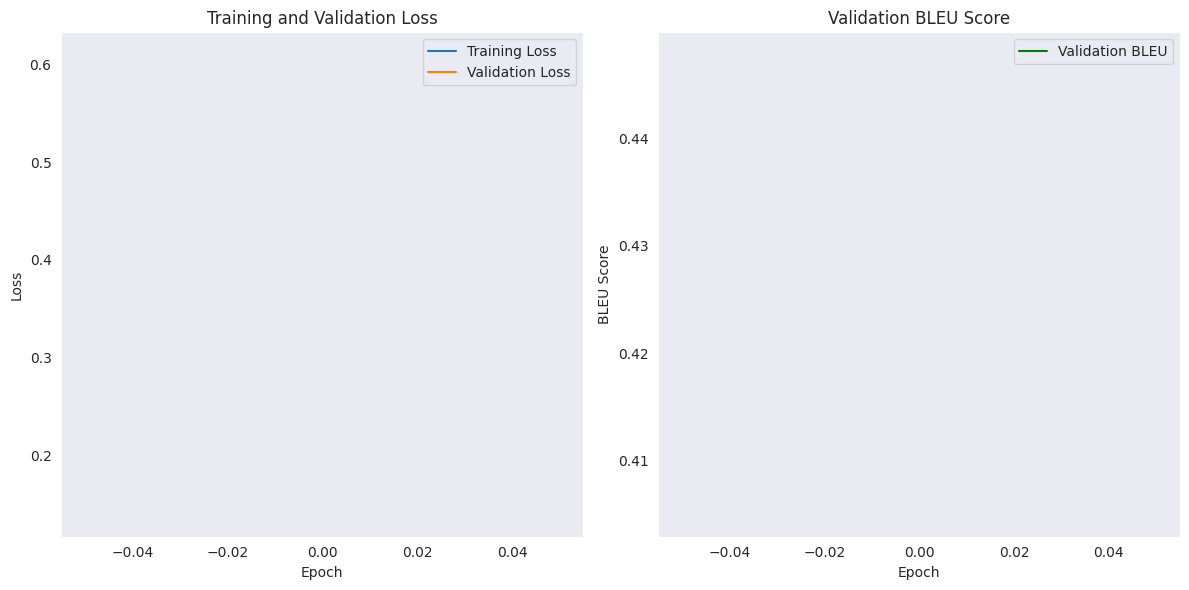

In [10]:
# Device setup
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#clear the cache
torch.cuda.empty_cache()

# Preprocessing setup
preprocessor = TranslationPreprocessor(tokenizer, lang_token, max_length)

# Shuffle the dataset before creating the data generator
new_dataset['train'] = new_dataset['train'].shuffle(seed=42)
new_dataset['validation'] = new_dataset['validation'].shuffle(seed=42)

# # Select 1000 samples for training and 200 for testing
# new_dataset['train'] = new_dataset['train'].select(range(1000))
# new_dataset['validation'] = new_dataset['validation'].select(range(200))

# Clear the cache
torch.cuda.empty_cache()

# Run training loop
history, last_batch_idx = train_model(
    model=model,
    train_dataset=new_dataset['train'],
    val_dataset=new_dataset['validation'],
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    tokenizer=tokenizer,
    device=device,
    preprocessor=preprocessor,
    LANG_TOKEN_MAPPING=lang_token,
    repo_name=repo_name
)

# Save final model

In [ ]:
# Save the final checkpoint
checkpoint_manager = CheckpointManager(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    tokenizer=tokenizer,
    repo_name="Lingua-Connect/backup",
    device=device
)

# Save the final model and tokenizer
checkpoint_manager.save_checkpoint(
    epoch=num_epochs - 1,  # Final epoch
    batch_idx=last_batch_idx,
    losses=history['train_loss']
)

print("Final model and tokenizer pushed to Hugging Face Hub.")

Checkpoint saved locally with learning rate: 1.11e-13, scheduler lr: 1.11e-13
Saved at epoch 10, batch 21046, steps_taken: None


model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

checkpoint.pth:   0%|          | 0.00/3.60G [00:00<?, ?B/s]

# Load saved model

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load the model and tokenizer from Hugging Face Hub
model = AutoModelForSeq2SeqLM.from_pretrained("Lingua-Connect/backup")
tokenizer = AutoTokenizer.from_pretrained("Lingua-Connect/backup")

# Move the model to the appropriate device
model.to(device)

print("Model and tokenizer loaded from Hugging Face Hub.")

# Perform inference

In [ ]:
def translate(text, source_lang="en", target_lang="sw", max_length=128, num_beams=5, num_return_sequences=1):

    # Add language token to the input text
    input_text = f"{lang_token[source_lang]} {text}"

    # Tokenize the input text
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=max_length, truncation=True)
    input_ids = input_ids.to(device)

    # Generate translation
    outputs = model.generate(
        input_ids,
        max_length=max_length,
        num_beams=num_beams,
        num_return_sequences=num_return_sequences,
        early_stopping=True  # Stop generation when the model outputs the EOS token
    )

    # Decode the generated tokens to text
    translated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

    return translated_texts

# Example usage
text_to_translate = "Hello, how are you?"
translated_texts = translate(text_to_translate, source_lang="en", target_lang="sw", num_beams=5, num_return_sequences=3)

print(f"Input: {text_to_translate}")
for i, translated_text in enumerate(translated_texts):
    print(f"Translation {i + 1}: {translated_text}")

In [ ]:
# Select a sample from the validation dataset
sample = validation_dataset[2]  # Change the index to test different samples
input_text = sample['English sentence']
target_text = sample['Swahili Translation']

# Translate the input text
translated_texts = translate(input_text, source_lang="en", target_lang="sw", num_beams=5, num_return_sequences=3)

# Print results
print(f"\nInput: {input_text}")
print(f"Target: {target_text}")
for i, translated_text in enumerate(translated_texts):
    print(f"Translation {i + 1}: {translated_text}")

In [ ]:
# def translate(text, model, tokenizer, lang_token, device, source_lang="en", target_lang="sw", max_length=128, num_beams=5, num_return_sequences=1):
#     """
#     Translate a sentence from the source language to the target language.
#     """
#     try:
#         # Ensure model is in eval mode
#         model.eval()

#         # Strip any extra whitespace and check if text is empty
#         text = text.strip()
#         if not text:
#             print("Error: Empty input text")
#             return []

#         # Add language token to the input text
#         input_text = f"{lang_token[source_lang]} {text}"
#         print(f"\nProcessing translation:")
#         print(f"Original text: {text}")
#         print(f"Text with language token: {input_text}")

#         # Tokenize the input text
#         with torch.no_grad():
#             input_ids = tokenizer.encode(
#                 input_text,
#                 return_tensors="pt",
#                 max_length=max_length,
#                 truncation=True,
#                 padding=True
#             )

#             # Move input to device and generate translation
#             input_ids = input_ids.to(device)

#             # Set the target language token as forced_bos_token_id
#             forced_bos_token_id = tokenizer.encode(lang_token[target_lang], add_special_tokens=False)[0]

#             outputs = model.generate(
#                 input_ids,
#                 max_length=max_length,
#                 num_beams=num_beams,
#                 num_return_sequences=num_return_sequences,
#                 early_stopping=True,
#                 forced_bos_token_id=forced_bos_token_id,
#                 pad_token_id=tokenizer.pad_token_id,
#                 bos_token_id=tokenizer.bos_token_id,
#                 eos_token_id=tokenizer.eos_token_id
#             )

#             # Decode the generated tokens to text
#             translated_texts = []
#             for output in outputs:
#                 decoded = tokenizer.decode(output, skip_special_tokens=True)
#                 # Remove the target language token from the beginning if present
#                 decoded = decoded.replace(lang_token[target_lang], "").strip()
#                 translated_texts.append(decoded)

#             return translated_texts

#     except Exception as e:
#         print(f"Error during translation: {str(e)}")
#         import traceback
#         traceback.print_exc()
#         return []

# def test_translation_pipeline(model, tokenizer, lang_token, device, validation_dataset=None):
#     """
#     Test the translation pipeline with both custom input and validation dataset examples.
#     """
#     print("\n=== Translation Pipeline Test ===")
#     print(f"Model device: {next(model.parameters()).device}")
#     print(f"Language tokens: {lang_token}")

#     # Test with custom input
#     test_texts = [
#         "Hello, how are you?",
#         "I love learning new languages.",
#         "What time is it?"
#     ]

#     print("\n1. Testing with custom inputs:")
#     for text in test_texts:
#         translations = translate(
#             text=text,
#             model=model,
#             tokenizer=tokenizer,
#             lang_token=lang_token,
#             device=device,
#             num_return_sequences=3
#         )

#         print(f"\nInput: {text}")
#         for i, translation in enumerate(translations, 1):
#             print(f"Translation {i}: {translation}")

#     # Test with validation dataset if available
#     if validation_dataset is not None:
#         print("\n2. Testing with validation dataset samples:")
#         for i in range(min(3, len(validation_dataset))):
#             sample = validation_dataset[i]
#             input_text = sample['English sentence']
#             target_text = sample['Swahili Translation']

#             translations = translate(
#                 text=input_text,
#                 model=model,
#                 tokenizer=tokenizer,
#                 lang_token=lang_token,
#                 device=device,
#                 num_return_sequences=3
#             )

#             print(f"\nInput: {input_text}")
#             print(f"Expected: {target_text}")
#             for i, translation in enumerate(translations, 1):
#                 print(f"Translation {i}: {translation}")

# # Usage example:
# if __name__ == "__main__":
#     # Make sure model is in eval mode
#     model.eval()

#     # Run the test pipeline
#     test_translation_pipeline(
#         model=model,
#         tokenizer=tokenizer,
#         lang_token=lang_token,
#         device=device,
#         validation_dataset=validation_dataset if 'validation_dataset' in locals() else None
#     )